#Import Necessary Libraries

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [67]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [68]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [69]:
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [70]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load the Dataset

In [72]:
df = pd.read_csv('APP.csv')

Explore the Data

In [73]:
df.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [75]:
df.describe()

,Review,label
count,52686,52702
unique,51472,2
top,Good,NEGATIVE
freq,153,29423


In [76]:
#Check for empty values
missing_values = df.isnull().sum()
missing_values

,0
Review,16
label,0


In [77]:
# Distribute values /in the label column
label_distribution = df['label'].value_counts()
label_distribution

,count
label,
NEGATIVE,29423
POSITIVE,23279


In [78]:
df= df.dropna()

<Axes: xlabel='label'>

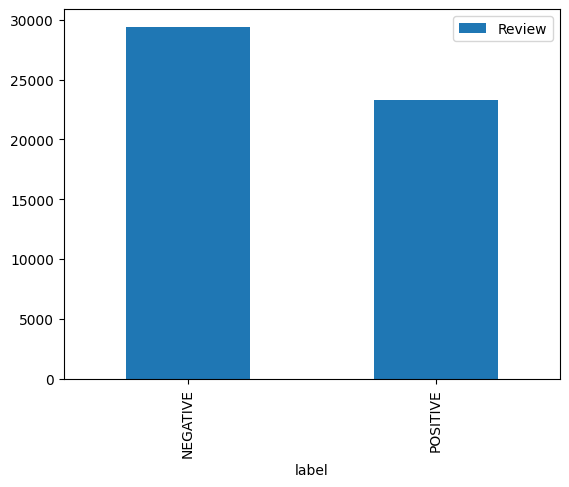

In [79]:
# The distribution of sentiments
df.groupby('label').count().plot(kind='bar')

In [80]:
# Calculate the length of each review and store it in a new column 'Review_length'
df['Review_length'] = df['Review'].apply(len)

# Now you can calculate the sentiment text length
sentiment_text_length = df.groupby('label')['Review_length'].agg(['mean', 'median', 'std'])
sentiment_text_length

,mean,median,std
label,,,
NEGATIVE,191.228733,161.0,124.811319
POSITIVE,100.998882,71.0,93.304315


<ipython-input-81-fc16dc4fa16a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="mean", data=sentiment_text_length, palette={'NEGATIVE': 'red', 'POSITIVE': 'green'})


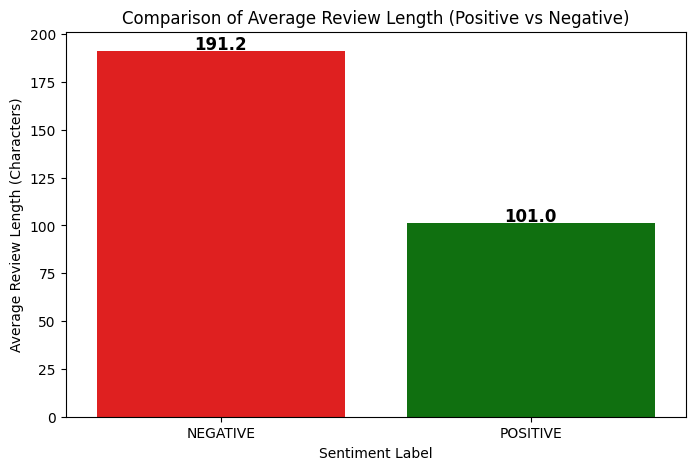

In [81]:
# Calculate the length of each review
df['Review_length'] = df['Review'].str.len()

# Compute statistics (mean, median, standard deviation) for each sentiment label
sentiment_text_length = df.groupby('label')['Review_length'].agg(['mean', 'median', 'std']).reset_index()

# Plot the bar chart using only the mean review length
plt.figure(figsize=(8, 5))

# Set the color palette for sentiment labels
sns.barplot(x="label", y="mean", data=sentiment_text_length, palette={'NEGATIVE': 'red', 'POSITIVE': 'green'})

# Add the value labels above each bar
for index, row in sentiment_text_length.iterrows():
    plt.text(index, row["mean"] + 1, round(row["mean"], 1), ha='center', fontsize=12, fontweight='bold')

# Customize the plot
plt.xlabel("Sentiment Label")
plt.ylabel("Average Review Length (Characters)")
plt.title("Comparison of Average Review Length (Positive vs Negative)")
plt.ylim(0, max(sentiment_text_length["mean"]) + 10)  # Set upper limit for Y-axis

# Show the plot
plt.show()


In [82]:
"""
#  (IQR)
Q1 = df['Review_length'].quantile(0.25)
Q3 = df['Review_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Show comments containing outliers
outliers = df[(df['Review_length'] < lower_bound) | (df['Review_length'] > upper_bound)]
print(outliers)
"""

"\n#  (IQR)\nQ1 = df['Review_length'].quantile(0.25)\nQ3 = df['Review_length'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n#Show comments containing outliers\noutliers = df[(df['Review_length'] < lower_bound) | (df['Review_length'] > upper_bound)]\nprint(outliers)\n"

#preprosing

In [109]:
"""
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["Cleaned_Review"] = df["Review"].apply(clean_text)

"""

In [122]:


# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    # Check if the input is a string; if not, convert it
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the 'Review' column
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Display the first 5 rows after cleaning
df[['Review', 'Cleaned_Review']].head()


,Review,Cleaned_Review
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...
2,"This pop-up ""Get the best Spotify experience o...",popup get best spotify experience android anno...
3,Really buggy and terrible to use as of recently,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song didnt put playlist shuff...


In [20]:
df['Review_Length'] = df['Cleaned_Review'].apply(len)
df['Word_Count'] = df['Cleaned_Review'].apply(lambda x: len(x.split()))
print(df[['Review_Length', 'Word_Count']].head())


   Review_Length  Word_Count
0             79          13
1             69          11
2             69          11
3             34           5
4             53           9


<ipython-input-21-f90b12b536f8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="mean", data=sentiment_text_length, palette={'NEGATIVE': 'red', 'POSITIVE': 'green'})


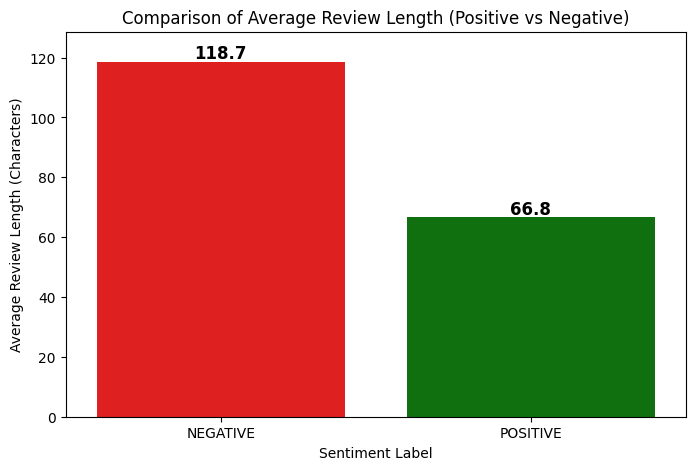

In [21]:

# Calculate the length of each comment
df['Word_Count'] = df['Cleaned_Review'].str.len()

# Calculate statistics for each category
sentiment_text_length = df.groupby('label')['Word_Count'].agg(['mean', 'median', 'std']).reset_index()

#Draw a chart using only "mean"
plt.figure(figsize=(8, 5))

# Updated palette to match the case of your labels
# Changed the palette keys to 'NEGATIVE' and 'POSITIVE'
sns.barplot(x="label", y="mean", data=sentiment_text_length, palette={'NEGATIVE': 'red', 'POSITIVE': 'green'})

# Add values ​​to each column
for index, row in sentiment_text_length.iterrows():
    plt.text(index, row["mean"] + 1, round(row["mean"], 1), ha='center', fontsize=12, fontweight='bold')


plt.xlabel("Sentiment Label")
plt.ylabel("Average Review Length (Characters)")
plt.title("Comparison of Average Review Length (Positive vs Negative)")
plt.ylim(0, max(sentiment_text_length["mean"]) + 10)

plt.show()

Encoder

In [84]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])


SPLIT

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Cleaned_Review'], df['label'], test_size=0.2, random_state=42)


##Tokenizer

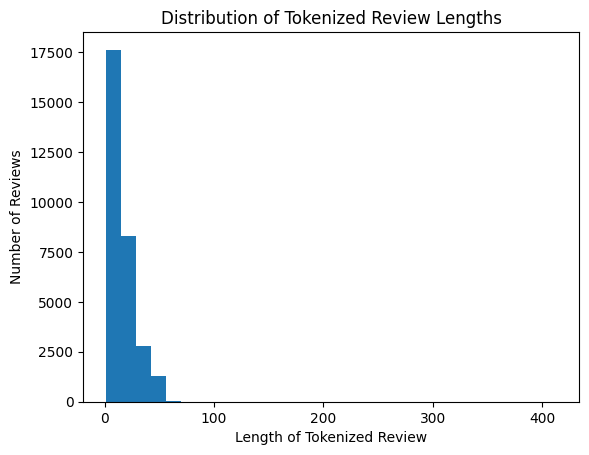

413


In [86]:
all_lengths = [len(seq) for seq in train_sequences]
import matplotlib.pyplot as plt

plt.hist(all_lengths, bins=30)
plt.xlabel('Length of Tokenized Review')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Tokenized Review Lengths')
plt.show()

print( max(all_lengths))


In [87]:
import numpy as np

# Calculate sequence lengths from the tokenized sequences (train_sequences)
sequence_lengths = [len(seq) for seq in train_sequences]

percentile_95 = int(np.percentile(sequence_lengths, 95))
print(f"The appropriate length to cover 95% of reviews is:{percentile_95} ")

The appropriate length to cover 95% of reviews is:41 


In [88]:
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
train_data = pad_sequences(train_sequences, maxlen=max_len,padding='post', truncating='post')
test_data = pad_sequences(test_sequences, maxlen=max_len,padding='post', truncating='post')


In [89]:

#GloVe embeddings
glove_path = "glove.6B.100d.txt"
embedding_dim = 100


In [90]:

def load_glove_embeddings(path, tokenizer, max_words, embedding_dim):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs

    embedding_matrix = np.zeros((max_words, embedding_dim))
    word_index = tokenizer.word_index
    for word, i in word_index.items():
        if i < max_words and word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

embedding_matrix = load_glove_embeddings(glove_path, tokenizer, max_words, embedding_dim)


#MODEL

In [91]:

#
model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(128, dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [92]:

# Preparing the form
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [93]:

# Adjusting callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [94]:

#Model training
history = model.fit(
    train_data, y_train,
    epochs=15, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 252s 457ms/step - accuracy: 0.7772 - loss: 0.4680 - val_accuracy: 0.8555 - val_loss: 0.3402 - learning_rate: 5.0000e-04
Epoch 2/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 256s 445ms/step - accuracy: 0.8518 - loss: 0.3505 - val_accuracy: 0.8609 - val_loss: 0.3234 - learning_rate: 5.0000e-04
Epoch 3/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 235s 445ms/step - accuracy: 0.8678 - loss: 0.3184 - val_accuracy: 0.8805 - val_loss: 0.2869 - learning_rate: 5.0000e-04
Epoch 4/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 237s 451ms/step - accuracy: 0.8795 - loss: 0.2953 - val_accuracy: 0.8849 - val_loss: 0.2789 - learning_rate: 5.0000e-04
Epoch 5/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 238s 452ms/step - accuracy: 0.8877 - loss: 0.2779 - val_accuracy: 0.8890 - val_loss: 0.2763 - learning_rate: 5.0000e-04
Epoch 6/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 261s 452ms/step - accuracy: 0.8897 - loss: 0.2742 - val_accuracy: 0.8926 - val_loss: 0.2663 - learning_rate: 5.0000e-04
Epoch 7/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 

In [95]:
# Evaluation on test data
loss, accuracy = model.evaluate(test_data, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Evaluation on train data
loss, accuracy = model.evaluate(train_data, y_train)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

# Predictions on test data
test_predictions = model.predict(test_data)
test_predicted_labels = (test_predictions > 0.5).astype(int).flatten()

# F1-score on test data
f1 = f1_score(y_test, test_predicted_labels, average='weighted')
print(f" Test F1 score: {f1:.4f}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step - accuracy: 0.9034 - loss: 0.2350
Test Accuracy: 90.00%
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 127s 96ms/step - accuracy: 0.9280 - loss: 0.1786
Train Accuracy: 92.42%
330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step
 Test F1 score: 0.8998


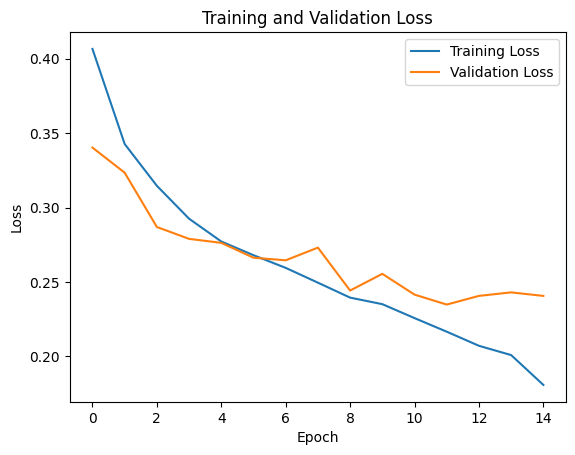

In [96]:
#  Plot loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

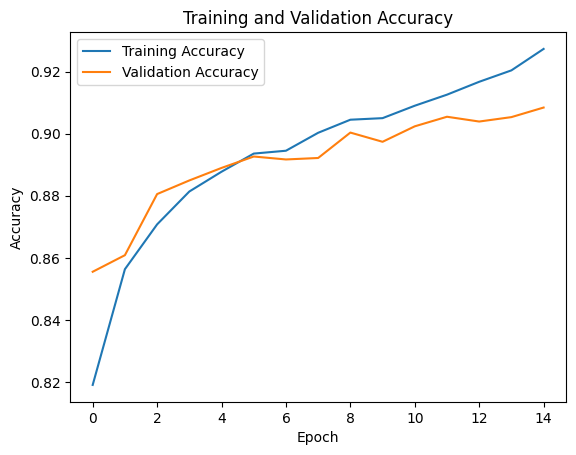

In [97]:
#  Plot acc

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#negative_reviews

###Import Necessary Libraries

In [110]:
# ipython-input-36-7b3e913a49f0
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from collections import Counter
# Import pad_sequences from tf.keras.utils instead of keras.preprocessing.sequence
from tensorflow.keras.utils import pad_sequences

##Create csv file

In [111]:
#  Convert all reviews to sequences and pad them
all_reviews = df['Cleaned_Review']
all_sequences = tokenizer.texts_to_sequences(all_reviews)
all_padded = pad_sequences(all_sequences, maxlen=max_len)

#  Predict sentiment using the trained model
predictions = model.predict(all_padded)
predicted_labels = (predictions > 0.5).astype(int).flatten()
df['Predicted_Sentiment'] = predicted_labels  # 0 = Negative, 1 = Positive

#  Extract only negative reviews
negative_reviews = df[df['Predicted_Sentiment'] == 0]['Cleaned_Review']
negative_reviews.to_csv('negative_reviews.csv', index=False)

1647/1647 ━━━━━━━━━━━━━━━━━━━━ 168s 102ms/step


##GloVe embeddings

In [112]:
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, max_words, embedding_dim)
embeddings_index = {
    tokenizer.index_word.get(i): embedding_matrix[i - 1]  # Adjust index by subtracting 1
    for i in range(1, len(tokenizer.word_index) + 1)
    if i <= max_words  # Ensure the index is within the bounds of embedding_matrix
}

In [113]:
# Convert each review to an average embedding vector
def get_average_embedding(text, embeddings_index, tokenizer, embedding_dim=100):
    words = tokenizer.texts_to_sequences([text])[0]
    if not words:
        return np.zeros(embedding_dim)
    word_embeddings = [
        embeddings_index.get(tokenizer.index_word.get(i), np.zeros(embedding_dim))
        for i in words
    ]
    return np.mean(word_embeddings, axis=0)

embeddings = np.array([
    get_average_embedding(text, embeddings_index, tokenizer, embedding_dim)
    for text in negative_reviews
])

##Clustering(KMeans)

In [114]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(embeddings)

#  Save clustered negative reviews
negative_reviews_df = pd.DataFrame(negative_reviews)
negative_reviews_df['Cluster'] = kmeans.labels_
negative_reviews_df.to_csv('negative_reviews_clusters_glove.csv', index=False)


In [115]:
#  Try different k values and compute Silhouette Score
for k in range(2, 6):
    kmeans_k = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans_k.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    print(f"k={k} => Silhouette Score = {score:.4f}")

k=2 => Silhouette Score = 0.1142
k=3 => Silhouette Score = 0.0734
k=4 => Silhouette Score = 0.0558
k=5 => Silhouette Score = 0.0445


In [116]:
#  Evaluate cluster quality and show review distribution
df_negative = pd.read_csv('negative_reviews_clusters_glove.csv')
silhouette_avg = silhouette_score(embeddings, df_negative["Cluster"])
print(f" Silhouette Score: {silhouette_avg:.4f} (closer to 1 is better)")
print("\n Review distribution per cluster:")
print(df_negative["Cluster"].value_counts())

 Silhouette Score: 0.1142 (closer to 1 is better)

 Review distribution per cluster:
Cluster
0    14175
1    12448
Name: count, dtype: int64


In [117]:
#  Display sample reviews from each cluster
num_clusters = 2
for cluster_num in range(num_clusters):
    print(f"\n🔹 Issue #{cluster_num + 1}:")
    print(df_negative[df_negative["Cluster"] == cluster_num]['Cleaned_Review']
          .sample(3, random_state=42).tolist())



🔹 Issue #1:
['i give only one star because too much of ad after every song 1 mins ad too much of ad it s irritating', 'what are you looking for i promise you spotify probably has it it s very rare to not find a band on this platform it does suck at times tho for the fact they may not have all the albums for that band i use spotify every day while at work and i have not been let down don t get basic pay for the sucker and you won t be bummed', 'samsung s8 and s10 app opens but get the loading circle after you select a playlist and it never loads no matter how long you wait']

🔹 Issue #2:
['i can t play any song that i pick randomly cuts halfway through a song and 6 skips an hour shouldn t be a feature i have no trouble with this on a console like playstation but this is just generally unusable', 'i am so angry at spotify on mobile whenever i m trying to listen to a song it plays something else and it makes the one song i wanted to listen to a playlist with a bunch of other songs i am s

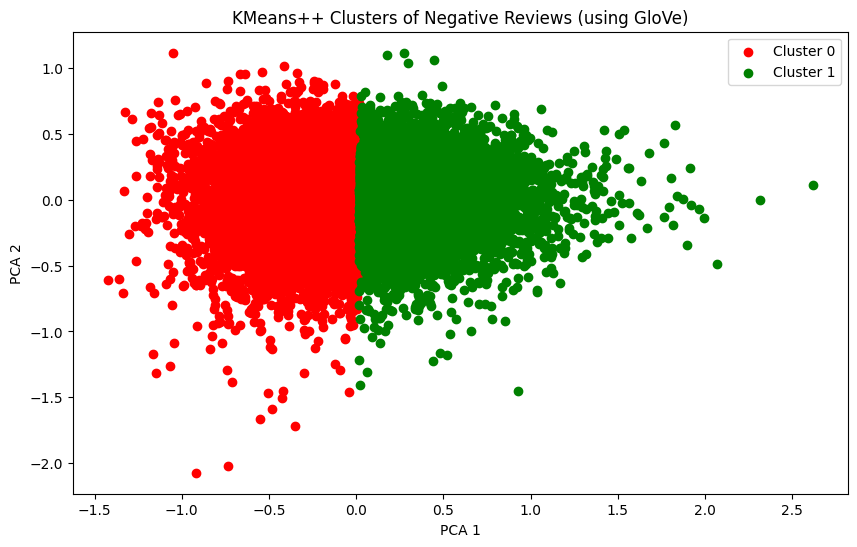

In [118]:
# Reduce dimensions for visualization (PCA)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot KMeans clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple', 'orange']
for i in range(num_clusters):
    plt.scatter(reduced[kmeans.labels_ == i, 0],
                reduced[kmeans.labels_ == i, 1],
                c=colors[i],
                label=f'Cluster {i}')
plt.legend()
plt.title('KMeans++ Clusters of Negative Reviews (using GloVe)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [ ]:
# Analyze top keywords per cluster
for cluster_num in range(num_clusters):
    cluster_reviews = df_negative[df_negative["Cluster"] == cluster_num]['Cleaned_Review']
    all_words = ' '.join(cluster_reviews).split()

    word_freq = Counter(all_words)
    common_words = word_freq.most_common(10)

    print(f"\n Top 10 keywords in Cluster {cluster_num}:")
    for word, count in common_words:
        print(f"{word}: {count}")

    main_issue = common_words[0][0]
    print(f"\n Most likely problem in Cluster {cluster_num}: '{main_issue}' related complaints")

##Word Cloud

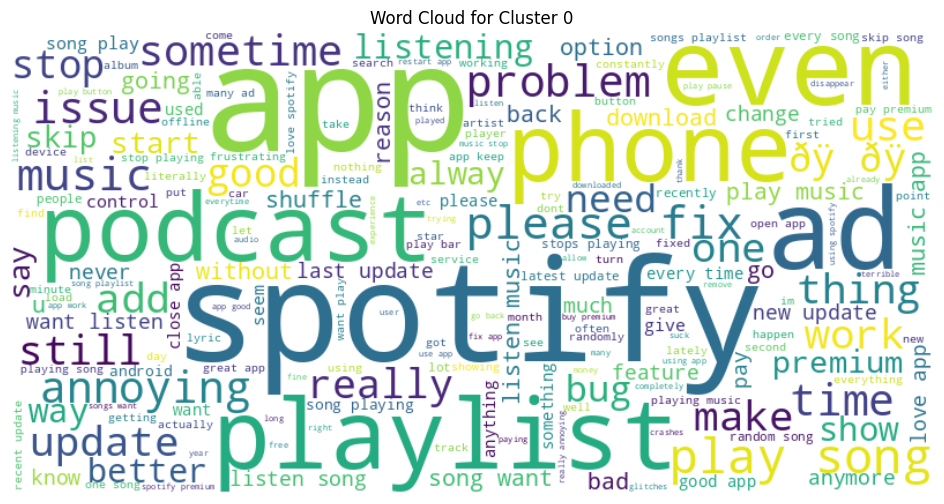

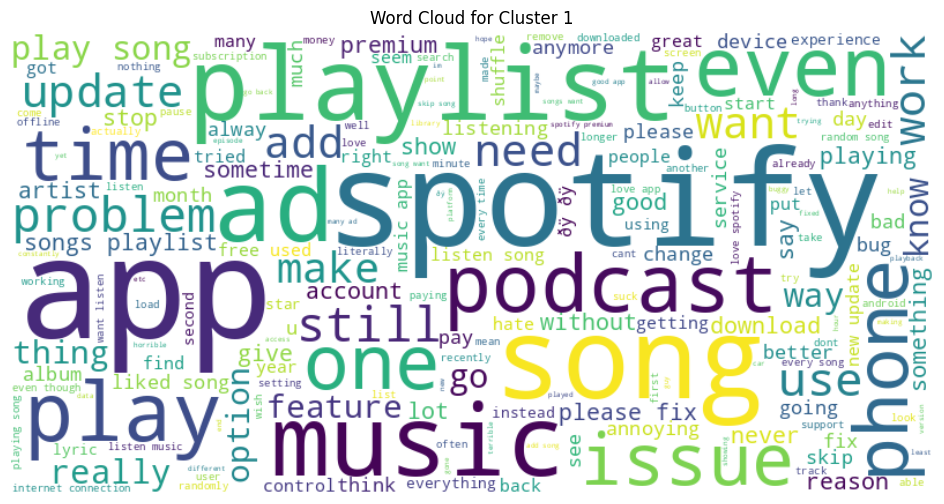

In [120]:
!pip install wordcloud
from wordcloud import WordCloud

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Get the number of unique clusters in the data
num_clusters = negative_reviews_df['Cluster'].nunique()

for cluster_num in range(num_clusters):  # Iterate through the actual number of clusters
    # Access the 'Cleaned_Review' column instead of 'Review'
    cluster_text = negative_reviews_df[negative_reviews_df['Cluster'] == cluster_num]['Cleaned_Review']
    combined_text = ' '.join(cluster_text)
    cleaned_text = remove_stopwords(combined_text)

    # Check if cleaned_text is empty before generating the word cloud
    if cleaned_text:  # Only generate if there is text
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cluster {cluster_num}')
        plt.show()
    else:
        print(f"No text found for cluster {cluster_num}, skipping word cloud generation.")

In [ ]:
# ✅ حفظ النموذج
model.save('sentiment_model.h5')
print('✔️ تم حفظ النموذج كـ sentiment_model.h5')

In [ ]:
# ✅ حفظ الـ Tokenizer
import json
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)
print("✔️ تم حفظ tokenizer.json")


In [ ]:
# ✅ تحميل الملفات من Google Colab
from google.colab import files
files.download('sentiment_model.h5')
files.download('tokenizer.json')